# Policy-based and actor-critic RL: DDPG, TD3, SAC, PPO
## Summary
    - DDPG learns a deterministic policy in continuous action spaces
    - Twin-delayed DDPG adds double learning, delayed parameter updates and external noise to output and target actions
    - SAC adds entropy for exploration, making it “soft”
    - PPO clips the ratio between new and old policies to prevent large policy updates

In [253]:
!nvidia-smi

Sat Jul 29 19:02:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:58:00.0 Off |                  N/A |
| N/A   77C    P0    N/A /  N/A |    731MiB /  2048MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [254]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set environment variables
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
# import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
# import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

# Define some constants
LEAVE_PRINT_EVERY_N_SECS = 100
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
# SEEDS = (12, 34, 56, 78, 90)

# Enable displaying Matplotlib plots in Jupyter Notebook
%matplotlib inline

In [255]:
# Set the 'fivethirtyeight' style for the plots
plt.style.use('fivethirtyeight')

# Set custom plot parameters for better visualization
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)

# Suppress scientific notation when printing arrays
np.set_printoptions(suppress=True)

In [256]:
#Check if CUDA is available
torch.cuda.is_available()

True

In [257]:
def get_make_env_fn(**kargs: Any) -> Tuple[Callable[..., gym.Env], dict]:
    """
    Get the make_env_fn function along with keyword arguments.

    Returns:
        Tuple[Callable[..., gym.Env], dict]: A tuple containing the make_env_fn function and keyword arguments.
    """

    def make_env_fn(
        env_name: str = "donkey-generated-track-v0",
        seed: Optional[int] = None,
        render: Optional[bool] = None,
        record: bool = False,
        unwrapped: bool = False,
        monitor_mode: Optional[int] = None,
        inner_wrappers: Optional[List[Callable[[gym.Env], gym.Env]]] = None,
        outer_wrappers: Optional[List[Callable[[gym.Env], gym.Env]]] = None,
    ) -> gym.Env:
        """
        Create and return a gym environment.

        Args:
            env_name (str, optional): The name of the gym environment. Defaults to "donkey-generated-track-v0".
            seed (int, optional): The random seed for the environment. Defaults to None.
            render (bool, optional): Whether to render the environment. Defaults to None.
            record (bool, optional): Whether to record the environment. Defaults to False.
            unwrapped (bool, optional): Whether to unwrap the environment. Defaults to False.
            monitor_mode (int, optional): The monitor mode for the environment. Defaults to None.
            inner_wrappers (List[Callable[[gym.Env], gym.Env]], optional): List of inner wrappers to apply to the environment. Defaults to None.
            outer_wrappers (List[Callable[[gym.Env], gym.Env]], optional): List of outer wrappers to apply to the environment. Defaults to None.

        Returns:
            gym.Env: The created gym environment.
        """

        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                }
                env = gym.make(env_name, conf=train_conf)
                # env = gym.make(env_name, render=render)
            except:
                pass
        if env is None:
            train_conf = {
                    "exe_path": "C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64",
                    "host": "127.0.0.1",
                    "port": 9091,
                    "car_name": "training",
                    "max_cte": 4.0,
                    "render": False
                }
            env = gym.make(env_name, conf=train_conf)
        if seed is not None:
            env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env,
            mdir,
            force=True,
            mode=monitor_mode,
            video_callable=lambda e_idx: record
        ) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env

    return make_env_fn, kargs


In [258]:
def get_videos_html(env_videos: List[Tuple[str, str]], title: str, max_n_videos: int = 4) -> Union[str, None]:
    """
    Generate HTML code to display videos with titles.

    Args:
        env_videos (List[Tuple[str, str]]): List of tuples containing video file paths and corresponding meta file paths.
        title (str): The title for the HTML section.
        max_n_videos (int, optional): The maximum number of videos to display. Defaults to 4.

    Returns:
        Union[str, None]: The HTML code as a string if videos are available, otherwise None.
    """

    videos = np.array(env_videos)

    if len(videos) == 0:
        return None

    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}</h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:
            meta = json.load(data_file)

        html_tag = """
        <h3>{}</h3>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))

    return strm

In [259]:
def get_gif_html(env_videos: List[Tuple[str, str]], title: str, subtitle_eps: Union[None, List[str]] = None, max_n_videos: int = 4) -> Union[str, None]:
    """
    Generate HTML code to display GIFs with titles.

    Args:
        env_videos (List[Tuple[str, str]]): List of tuples containing video file paths and corresponding meta file paths.
        title (str): The title for the HTML section.
        subtitle_eps (Union[None, List[str]], optional): List of subtitles for episodes. Defaults to None.
        max_n_videos (int, optional): The maximum number of videos to display. Defaults to 4.

    Returns:
        Union[str, None]: The HTML code as a string if videos are available, otherwise None.
    """

    videos = np.array(env_videos)

    if len(videos) == 0:
        return None

    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}</h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '7',
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm',
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert',
                 '-coalesce',
                 '-delay', '7',
                 '-loop', '0',
                 '-fuzz', '2%',
                 '+dither',
                 '-deconstruct',
                 '-layers', 'Optimize',
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        suffix = str(meta['episode_id'] if subtitle_eps is None else subtitle_eps[meta['episode_id']])
        strm += html_tag.format(prefix + suffix, encoded.decode('ascii'))
    return strm


In [260]:
class RenderUint8(gym.Wrapper):
    """
    Gym environment wrapper to convert the rendered frames to uint8 format.

    Args:
        env (gym.Env): The original Gym environment.

    Attributes:
        env (gym.Env): The original Gym environment wrapped by this class.
    """

    def __init__(self, env: gym.Env):
        """
        Initialize the RenderUint8 wrapper.

        Args:
            env (gym.Env): The original Gym environment.
        """
        super().__init__(env)

    def reset(self, **kwargs) -> np.ndarray:
        """
        Reset the environment.

        Args:
            **kwargs: Additional arguments to be passed to the reset function.

        Returns:
            np.ndarray: The initial observation after resetting the environment.
        """
        return self.env.reset(**kwargs)

    def render(self, mode: str = 'rgb_array') -> np.ndarray:
        """
        Render the environment.

        Args:
            mode (str, optional): The rendering mode. Defaults to 'rgb_array'.

        Returns:
            np.ndarray: The rendered frame as a numpy array in uint8 format.
        """
        frame = self.env.render(mode=mode)
        return frame.astype(np.uint8)


# SAC
<img src="../blob/img/08_sac.png" alt= “” width="600" height="300">

## FCQSA

In [264]:
class FCQSA(nn.Module):
    """
    Fully Connected Q-Value Network with State and Action inputs.

    Args:
        input_dim (int): The dimension of the input state.
        output_dim (int): The dimension of the output action.
        obs_space_size (int, optional): The size of the observation space. Defaults to 32.
        hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
        activation_fc (function, optional): The activation function to be used. Defaults to F.relu.

    Attributes:
        activation_fc (function): The activation function used in the network.
        input_layer (nn.Linear): The input layer of the network.
        hidden_layers (nn.ModuleList): A list of hidden layers in the network.
        output_layer (nn.Linear): The output layer of the network.
        device (torch.device): The device on which the network is stored.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        obs_space_size: int = 32,
        hidden_dims: Tuple[int, int] = (32, 32),
        activation_fc: function = F.relu,
    ):
        """
        Initialize the FCQSA network.

        Args:
            input_dim (int): The dimension of the input state.
            output_dim (int): The dimension of the output action.
            obs_space_size (int, optional): The size of the observation space. Defaults to 32.
            hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
            activation_fc (function, optional): The activation function to be used. Defaults to F.relu.
        """
        super(FCQSA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state: np.ndarray, action: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Format the state and action as torch Tensors.

        Args:
            state (np.ndarray): The input state.
            action (np.ndarray): The input action.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tensors representing the state and action.
        """
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, device=self.device, dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state: np.ndarray, action: np.ndarray) -> torch.Tensor:
        """
        Perform a forward pass through the network.

        Args:
            state (np.ndarray): The input state.
            action (np.ndarray): The input action.

        Returns:
            torch.Tensor: The Q-value output of the network.
        """
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def load(self, experiences) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load experiences and convert them to Torch Tensors.

        Args:
            experiences: A tuple of experiences containing states, actions, new_states, rewards, and is_terminals.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Tensors representing states, actions, new states, rewards, and is_terminals.
        """
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals


## FCGP

In [265]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal
from typing import Tuple

class FCGP(nn.Module):
    """
    Fully Connected Gaussian Policy.

    Args:
        input_dim (int): The dimension of the input state.
        action_bounds (Tuple[float, float]): A tuple representing the bounds of the action space.
        log_std_min (float, optional): The minimum value of the logarithm of the standard deviation. Defaults to -20.
        log_std_max (float, optional): The maximum value of the logarithm of the standard deviation. Defaults to 2.
        hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
        activation_fc (function, optional): The activation function to be used. Defaults to F.relu.
        entropy_lr (float, optional): The learning rate for entropy optimization. Defaults to 0.001.

    Attributes:
        activation_fc (function): The activation function used in the network.
        env_min (torch.Tensor): The minimum values of the action space.
        env_max (torch.Tensor): The maximum values of the action space.
        log_std_min (float): The minimum value of the logarithm of the standard deviation.
        log_std_max (float): The maximum value of the logarithm of the standard deviation.
        input_layer (nn.Linear): The input layer of the network.
        hidden_layers (nn.ModuleList): A list of hidden layers in the network.
        output_layer_mean (nn.Linear): The output layer for the mean of the action distribution.
        output_layer_log_std (nn.Linear): The output layer for the logarithm of the standard deviation of the action distribution.
        device (torch.device): The device on which the network is stored.
        nn_min (torch.Tensor): The minimum value of the action space (tanh scaled).
        nn_max (torch.Tensor): The maximum value of the action space (tanh scaled).
        rescale_fn (function): A function to rescale actions from tanh space to the original action space.
        target_entropy (float): The target entropy for entropy optimization.
        logalpha (torch.Tensor): The logarithm of the entropy coefficient.
        alpha_optimizer (torch.optim.Adam): The optimizer for entropy optimization.
    """

    def __init__(
        self,
        input_dim: int,
        action_bounds: Tuple[float, float],
        log_std_min: float = -20,
        log_std_max: float = 2,
        hidden_dims: Tuple[int, int] = (32, 32),
        activation_fc: function = F.relu,
        entropy_lr: float = 0.001,
    ):
        """
        Initialize the FCGP network.

        Args:
            input_dim (int): The dimension of the input state.
            action_bounds (Tuple[float, float]): A tuple representing the bounds of the action space.
            log_std_min (float, optional): The minimum value of the logarithm of the standard deviation. Defaults to -20.
            log_std_max (float, optional): The maximum value of the logarithm of the standard deviation. Defaults to 2.
            hidden_dims (Tuple[int, int], optional): A tuple of integers representing the sizes of hidden layers. Defaults to (32, 32).
            activation_fc (function, optional): The activation function to be used. Defaults to F.relu.
            entropy_lr (float, optional): The learning rate for entropy optimization. Defaults to 0.001.
        """
        super(FCGP, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min, device=self.device, dtype=torch.float32)
        self.env_max = torch.tensor(self.env_max, device=self.device, dtype=torch.float32)

        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _format(self, state: np.ndarray) -> torch.Tensor:
        """
        Format the state as a torch Tensor.

        Args:
            state (np.ndarray): The input state.

        Returns:
            torch.Tensor: The formatted state as a tensor.
        """
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
        return x.view(-1, 32)

    def forward(self, state: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Perform a forward pass through the network.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The mean and log standard deviation of the action distribution.
        """
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, self.log_std_min, self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state: np.ndarray, epsilon: float = 1e-6) -> Tuple[np.ndarray, torch.Tensor, np.ndarray]:
        """
        Perform a full pass through the network including action sampling and rescaling.

        Args:
            state (np.ndarray): The input state.
            epsilon (float, optional): A small value for numerical stability. Defaults to 1e-6.

        Returns:
            Tuple[np.ndarray, torch.Tensor, np.ndarray]: The sampled action, log probability, and rescaled action.
        """
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
            (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def _update_exploration_ratio(self, greedy_action: np.ndarray, action_taken: np.ndarray):
        """
        Update the exploration ratio based on the greedy and taken actions.

        Args:
            greedy_action (np.ndarray): The greedy action.
            action_taken (np.ndarray): The taken action.
        """
        env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
        self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

    def _get_actions(self, state: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get actions based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: The sampled action, greedy action, and random action.
        """
        if len(state) != 32 and state.shape != (1, 32):
            state = encode_from_image(state, 0.0)
        mean, log_std = self.forward(state)

        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        greedy_action = self.rescale_fn(torch.tanh(mean))
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy(),
                                          size=(2,))

        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        random_action = random_action.reshape(action_shape)

        return action, greedy_action, random_action

    def select_random_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select a random action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The randomly sampled action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, random_action)
        return random_action

    def select_greedy_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select the greedy action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The greedy action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, greedy_action)
        return greedy_action

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select an action based on the input state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            np.ndarray: The selected action.
        """
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, action)
        return action


## SAC Model

In [266]:
class SAC:
    def __init__(
        self,
        replay_buffer_fn: Callable,
        policy_model_fn: Callable,
        policy_max_grad_norm: float,
        policy_optimizer_fn: Callable,
        policy_optimizer_lr: float,
        value_model_fn: Callable,
        value_max_grad_norm: float,
        value_optimizer_fn: Callable,
        value_optimizer_lr: float,
        n_warmup_batches: int,
        update_target_every_steps: int,
        tau: float,
    ):
        """
        Soft Actor-Critic (SAC) algorithm.

        Args:
            replay_buffer_fn: A function that returns an instance of a replay buffer class.
            policy_model_fn: A function that returns an instance of the policy model class.
            policy_max_grad_norm: Maximum gradient norm for the policy model optimization.
            policy_optimizer_fn: A function that returns the policy optimizer instance.
            policy_optimizer_lr: Learning rate for the policy optimizer.
            value_model_fn: A function that returns an instance of the value model class.
            value_max_grad_norm: Maximum gradient norm for the value models' optimization.
            value_optimizer_fn: A function that returns the value models' optimizer instances.
            value_optimizer_lr: Learning rate for the value models' optimizers.
            n_warmup_batches: Number of warm-up batches before the policy optimization starts.
            update_target_every_steps: Number of steps to perform target network updates.
            tau: Target network update rate.

        Attributes:
            replay_buffer_fn (Callable): Function returning the replay buffer instance.
            policy_model_fn (Callable): Function returning the policy model instance.
            policy_max_grad_norm (float): Maximum gradient norm for policy model optimization.
            policy_optimizer_fn (Callable): Function returning the policy optimizer instance.
            policy_optimizer_lr (float): Learning rate for the policy optimizer.
            value_model_fn (Callable): Function returning the value model instance.
            value_max_grad_norm (float): Maximum gradient norm for value model optimization.
            value_optimizer_fn (Callable): Function returning the value model optimizer instances.
            value_optimizer_lr (float): Learning rate for the value model optimizers.
            n_warmup_batches (int): Number of warm-up batches before policy optimization.
            update_target_every_steps (int): Number of steps to perform target network updates.
            tau (float): Target network update rate.
        """
        self.replay_buffer_fn = replay_buffer_fn
        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

        self.policy_model = None
        self.online_value_model_a = None
        self.online_value_model_b = None
        self.target_value_model_a = None
        self.target_value_model_b = None
        self.value_optimizer_a = None
        self.value_optimizer_b = None
        self.policy_optimizer = None
        self.replay_buffer = None
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []
        self.gamma = None
        self.checkpoint_dir = None
        self.make_env_fn = None
        self.make_env_kargs = None
        self.seed = None

    def optimize_model(self, experiences: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]):
        """
        Optimize the SAC agent's policy and value models using the given experiences.

        Args:
            experiences: Tuple of (states, actions, rewards, next_states, is_terminals) from the replay buffer.
        """
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        # Enable anomaly detection for debugging
        torch.autograd.set_detect_anomaly(True)

        # policy loss
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s.detach() - current_q_sa.detach()).mean()

        # Q loss
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(), self.value_max_grad_norm)
        self.value_optimizer_b.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()

    def interaction_step(self, state: np.ndarray, env) -> Tuple[np.ndarray, bool]:
        """
        Perform an interaction step between the agent and the environment.

        Args:
            state: Current state of the environment.
            env: Environment instance.

        Returns:
            Tuple containing the new state and a boolean indicating if the episode is terminated.
        """
        if len(state) != 32 and state.shape != (1, 32):
            state = encode_from_image(state, 0.0)
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action(state)
        else:
            action = self.policy_model.select_action(state)

        new_state, reward, is_terminal, info = env.step(action)
        new_state = encode_from_image(new_state, info)

        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.policy_model.exploration_ratio
        return new_state, is_terminal

    def update_value_networks(self, tau=None):
        """
        Update the target value networks using Polyak averaging.

        Args:
            tau (float, optional): Target network update rate. If not provided, use the class attribute tau.
        """
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model_a.parameters(), self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(
        self,
        make_env_fn: Callable,
        make_env_kargs: dict,
        seed: int,
        gamma: float,
        max_minutes: int,
        max_episodes: int,
        goal_mean_100_reward: float
    ) -> Tuple[np.ndarray, float, float, float]:
        """
        Train the agent using the SAC algorithm.

        Args:
            make_env_fn: Function returning the environment instance.
            make_env_kargs: Keyword arguments for environment creation.
            seed: Seed for random number generation.
            gamma: Discount factor for future rewards.
            max_minutes: Maximum training time in minutes.
            max_episodes: Maximum number of episodes for training.
            goal_mean_100_reward: Target mean 100-episode evaluation reward.

        Returns:
            Tuple containing training results and final evaluation score.
        """
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = os.path.join(os.path.dirname("__file__"), "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma

        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        nS, nA = 32, env.action_space.shape[0]
        action_bounds = [-0.5, 0], [0.5, 1]
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)
        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)
        self.update_value_networks(tau=1.0)

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a, self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b, self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0

        for episode in range(1, max_episodes + 1):
            episode_start = time.time()

            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if is_terminal:
                    gc.collect()
                    break

            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(self.episode_exploration[-100:]) / np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed

            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close()
        del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_policy_model, eval_env, n_episodes=1) -> Tuple[float, float]:
        """
        Evaluate the agent using the given evaluation policy model and environment.

        Args:
            eval_policy_model: Policy model to evaluate.
            eval_env: Environment instance for evaluation.
            n_episodes: Number of episodes for evaluation.

        Returns:
            Tuple containing the mean and standard deviation of the evaluation rewards.
        """
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d:
                    break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4) -> dict:
        """
        Clean up and return the checkpoint paths.

        Args:
            n_checkpoints: Number of checkpoints to keep.

        Returns:
            Dictionary containing checkpoint paths for selected checkpoints.
        """
        try:
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]): path for path in paths}
        last_ep = max(paths_dic.keys())
        checkpoint_idxs = np.linspace(1, last_ep + 1, n_checkpoints, endpoint=True, dtype=np.int64) - 1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2) -> List[int]:
        """
        Demonstrate the agent using the last checkpoint.

        Args:
            title: Title for the demonstration.
            n_episodes: Number of episodes for demonstration.
            max_n_videos: Maximum number of videos to display.

        Returns:
            List containing episode indices of the checkpoints used for demonstration.
        """
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))
        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        del env
        return list(checkpoint_paths.keys())

    def demo_progression(self, title='{} Agent progression', max_n_videos=4) -> List[int]:
        """
        Demonstrate the agent's progression using checkpoints.

        Args:
            title: Title for the demonstration.
            max_n_videos: Maximum number of videos to display.

        Returns:
            List containing episode indices of the checkpoints used for demonstration.
        """
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        del env
        return list(checkpoint_paths.keys())

    def save_checkpoint(self, episode_idx: int, model):
        """
        Save the checkpoint of the model.

        Args:
            episode_idx: Episode index for the checkpoint.
            model: Model instance to be saved.
        """
        torch.save(model.state_dict(), os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))


## Replay Buffer

In [267]:
class ReplayBuffer:
    """
    A simple replay buffer for storing and sampling experiences.

    Args:
        max_size (int): The maximum number of experiences the buffer can hold.
        batch_size (int): The size of the batch to sample during training.
    """

    def __init__(self, max_size: int = 10000, batch_size: int = 64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]):
        """
        Store an experience sample in the replay buffer.

        Args:
            sample (Tuple): A tuple containing the state, action, reward, next state, and done flag.
        """
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Sample a batch of experiences from the replay buffer.

        Args:
            batch_size (int, optional): The size of the batch to sample. If None, the buffer's batch size will be used.

        Returns:
            Tuple: A tuple containing the states, actions, rewards, next states, and done flags of the sampled batch.
        """
        if batch_size is None:
            batch_size = self.batch_size

        idxs = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self) -> int:
        """
        Get the current size of the replay buffer.

        Returns:
            int: The size of the replay buffer.
        """
        return self.size


In [269]:
import gym

PATH_TO_APP = r"C:\Users\Phili\Desktop\RL_Project\DonkeySimWin"
exe_path = f"{PATH_TO_APP}/donkey_sim.exe"
port = 9091

conf = {"exe_path": exe_path, "port": port}

env = gym.make("donkey-generated-track-v0", conf=conf)

# Now you can interact with the environment as you would with any other Gym environment
observation = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Replace this with your policy's action selection
    observation, reward, done, info = env.step(action)

# Don't forget to close the environment when you're done
env.close()


## Autoencoder


In [270]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname("__file__"), "RL_gh/twitch/"))
import tensorflow as tf
from ae.autoencoder import load_ae
import cv2
import matplotlib.pyplot as plt

In [271]:
# model and test_pictures_path
model_path = r"C:\Users\Phili\Desktop\RL_Project\RL_gh\ae-32_1689619355_best.pkl"
test_pictures_path = r"C:\Users\Phili\Desktop\RL_Project\RL_gh\twitch\logs\dataset-test\\"

In [272]:
import numpy as np

def load_ae(model_path: str) -> YourAutoEncoderModelType:
    """
    Load an autoencoder model from the specified file path.

    Parameters:
        model_path (str): The file path to the pre-trained autoencoder model.

    Returns:
        YourAutoEncoderModelType: The loaded autoencoder model.
    """
    # Your implementation to load the autoencoder model from model_path.
    # Replace YourAutoEncoderModelType with the actual type of the autoencoder model.

# Assuming that ae_model is loaded with an autoencoder model before calling the function.
ae_model = load_ae(model_path)

def encode_from_image(obs: np.array, infos: dict) -> np.array:
    """
    Encode an image observation using the pre-trained autoencoder model.

    Parameters:
        obs (np.array): The image observation to be encoded.
        infos (dict): Additional information related to the observation.

    Returns:
        np.array: The encoded representation of the image.
    """
    global ae_model
    encoded_image = ae_model.encode_from_raw_image(obs[:, :, ::-1])
    # Note: The parameter 'infos' is not used in the current implementation.
    # If you plan to use 'infos' in the future, uncomment and modify the relevant lines.

    # speed = infos["speed"]
    # new_obs = np.concatenate([encoded_image.flatten(), [speed]])
    return encoded_image


Dim AE = 32
PyTorch 1.11.0


In [274]:
SEEDS = [12]

## Training loop

In [280]:
# Load the autoencoder model from the specified path
model_path = r"C:\Users\Phili\Desktop\RL_Project\RL_gh\ae-32_1689619355_best.pkl"
ae_model = load_ae(model_path)

def encode_from_image(obs: np.array, infos: dict) -> np.array:
    """
    Encode an image observation using the pre-trained autoencoder model.

    Parameters:
        obs (np.array): The image observation to be encoded.
        infos (dict): Additional information related to the observation.

    Returns:
        np.array: The encoded representation of the image.
    """
    global ae_model
    encoded_image = ae_model.encode_from_raw_image(obs[:, :, ::-1])
    # Note: The parameter 'infos' is not used in the current implementation.
    # If you plan to use 'infos' in the future, uncomment and modify the relevant lines.

    # speed = infos["speed"]
    # new_obs = np.concatenate([encoded_image.flatten(), [speed]])
    return encoded_image

# Constants and settings
SEEDS = [1, 2, 3, 4]  # Replace with the actual list of seeds
sac_results = []
best_agent, best_eval_score = None, float('-inf')

# Loop through each seed
for seed in SEEDS:
    environment_settings = {
        'env_name': "donkey-mountain-track-v0",
        'gamma': 0.8,
        'max_minutes': 120,
        'max_episodes': 3000,
        'goal_mean_100_reward': 2000
    }

    policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(32, 32))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.001

    value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(32, 32))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)
    n_warmup_batches = 7
    update_target_every_steps = 1
    tau = 0.001

    # Extract environment settings
    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()

    # Create the SAC agent with the specified settings
    agent = SAC(replay_buffer_fn, policy_model_fn, policy_max_grad_norm, policy_optimizer_fn, policy_optimizer_lr,
                value_model_fn, value_max_grad_norm, value_optimizer_fn, value_optimizer_lr, n_warmup_batches,
                update_target_every_steps, tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)

    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent

sac_results = np.array(sac_results)
_ = BEEP()


starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


In [ ]:
# best_agent = SAC(replay_buffer_fn,
#                 policy_model_fn, 
#                 policy_max_grad_norm,
#                 policy_optimizer_fn, 
#                 policy_optimizer_lr,
#                 value_model_fn,
#                 value_max_grad_norm, 
#                 value_optimizer_fn, 
#                 value_optimizer_lr, 
#                 n_warmup_batches,
#                 update_target_every_steps,
#                 tau)

In [ ]:
# make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
# result, final_eval_score, training_time, wallclock_time = agent.train(
#     make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
# sac_results.append(result)
# if final_eval_score > best_eval_score:
#     best_eval_score = final_eval_score
#     best_agent = agent
# sac_results = np.array(sac_results)
# _ = BEEP()

In [ ]:
# manually restart env
best_agent.demo_progression()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
C:/Users/Phili/Desktop/RL_Project/DonkeySimWin/donkey_sim.x86_64 does not exist. you must start sim manually.


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 


loading scene generated_track


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


dict_keys([0, 1295, 2590, 3886])

In [278]:
best_agent.demo_last()

AttributeError: 'NoneType' object has no attribute 'demo_last'

In [ ]:
# Assuming you have already defined the sac_results array

# Calculate maximum values for each column
sac_max_t, sac_max_r, sac_max_s, sac_max_sec, sac_max_rt = np.max(sac_results, axis=0).T

# Calculate minimum values for each column
sac_min_t, sac_min_r, sac_min_s, sac_min_sec, sac_min_rt = np.min(sac_results, axis=0).T

# Calculate mean values for each column
sac_mean_t, sac_mean_r, sac_mean_s, sac_mean_sec, sac_mean_rt = np.mean(sac_results, axis=0).T

# Create x values for plotting (assuming the length of sac_mean_s is used)
sac_x = np.arange(len(sac_mean_s))


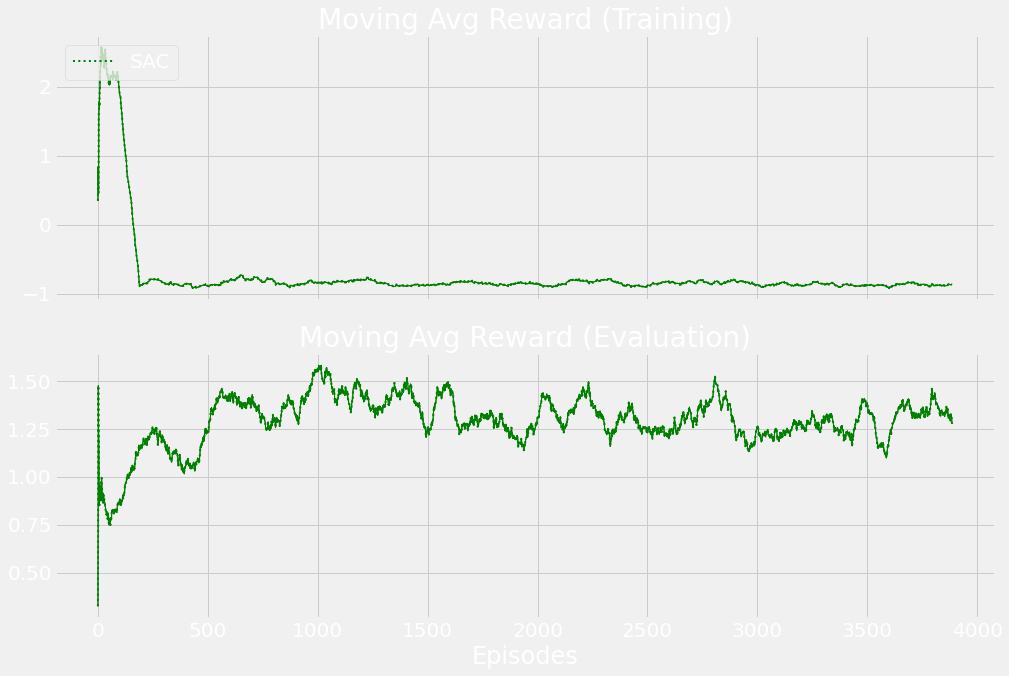

In [ ]:
def plot_sac_results(sac_max_r, sac_min_r, sac_mean_r, sac_max_s, sac_min_s, sac_mean_s, sac_x):
    """
    Plot the SAC (Soft Actor-Critic) results.

    Args:
        sac_max_r (numpy.ndarray): Array of maximum reward values for SAC.
        sac_min_r (numpy.ndarray): Array of minimum reward values for SAC.
        sac_mean_r (numpy.ndarray): Array of mean reward values for SAC.
        sac_max_s (numpy.ndarray): Array of maximum evaluation scores for SAC.
        sac_min_s (numpy.ndarray): Array of minimum evaluation scores for SAC.
        sac_mean_s (numpy.ndarray): Array of mean evaluation scores for SAC.
        sac_x (numpy.ndarray): Array of x values for plotting.

    Returns:
        None
    """
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharey=False, sharex=True)

    # SAC - Moving Avg Reward (Training)
    axs[0].plot(sac_max_r, 'g', linewidth=1)
    axs[0].plot(sac_min_r, 'g', linewidth=1)
    axs[0].plot(sac_mean_r, 'g:', label='SAC', linewidth=2)
    axs[0].fill_between(sac_x, sac_min_r, sac_max_r, facecolor='g', alpha=0.3)

    # SAC - Moving Avg Reward (Evaluation)
    axs[1].plot(sac_max_s, 'g', linewidth=1)
    axs[1].plot(sac_min_s, 'g', linewidth=1)
    axs[1].plot(sac_mean_s, 'g:', label='SAC', linewidth=2)
    axs[1].fill_between(sac_x, sac_min_s, sac_max_s, facecolor='g', alpha=0.3)

    # Plot titles and labels
    axs[0].set_title('Moving Avg Reward (Training)')
    axs[1].set_title('Moving Avg Reward (Evaluation)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

    plt.show()

# Assuming you have the arrays sac_max_r, sac_min_r, sac_mean_r, sac_max_s, sac_min_s, sac_mean_s, and sac_x defined
plot_sac_results(sac_max_r, sac_min_r, sac_mean_r, sac_max_s, sac_min_s, sac_mean_s, sac_x)

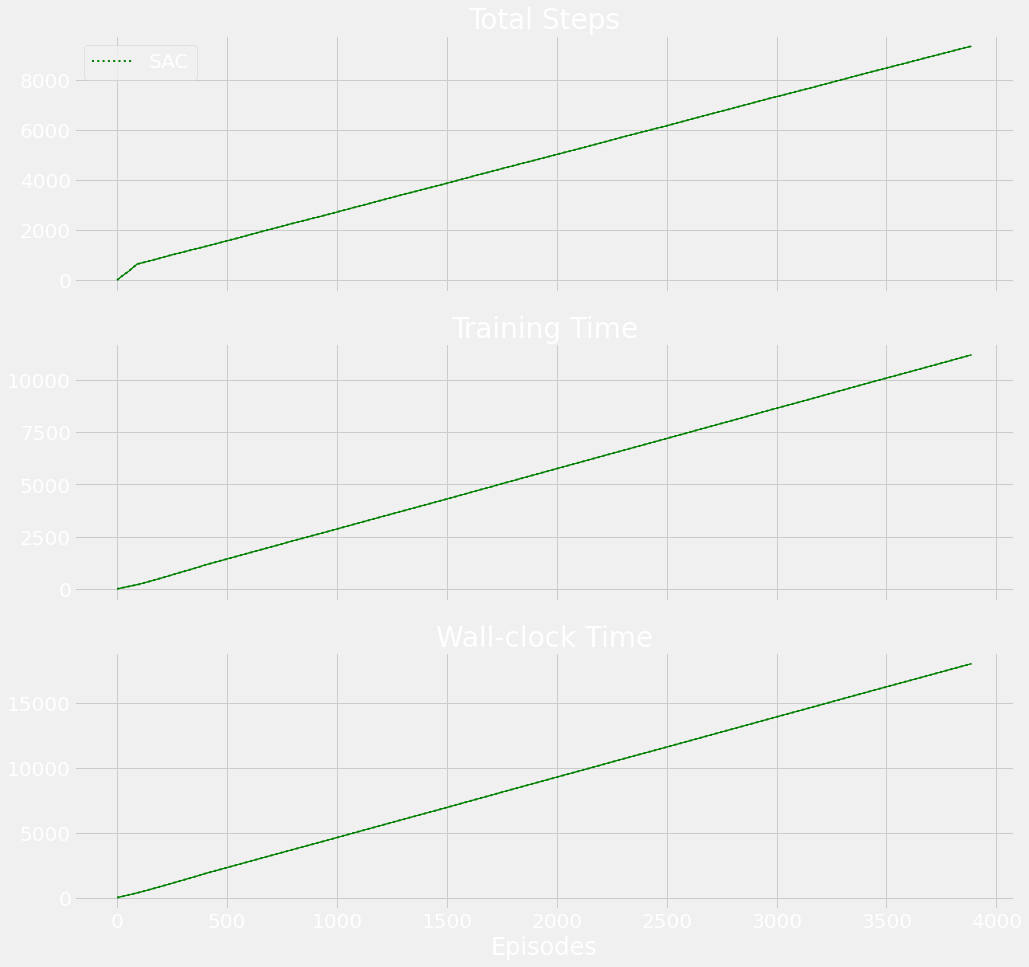

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharey=False, sharex=True)

# SAC - Total Steps
axs[0].plot(sac_max_t, 'g', linewidth=1)
axs[0].plot(sac_min_t, 'g', linewidth=1)
axs[0].plot(sac_mean_t, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(sac_x, sac_min_t, sac_max_t, facecolor='g', alpha=0.3)

# SAC - Training Time
axs[1].plot(sac_max_sec, 'g', linewidth=1)
axs[1].plot(sac_min_sec, 'g', linewidth=1)
axs[1].plot(sac_mean_sec, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(sac_x, sac_min_sec, sac_max_sec, facecolor='g', alpha=0.3)

# SAC - Wall-clock Time
axs[2].plot(sac_max_rt, 'g', linewidth=1)
axs[2].plot(sac_min_rt, 'g', linewidth=1)
axs[2].plot(sac_mean_rt, 'g:', label='SAC', linewidth=2)
axs[2].fill_between(sac_x, sac_min_rt, sac_max_rt, facecolor='g', alpha=0.3)

# Plot titles and labels
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')

plt.show()


In [ ]:
# Create SAC results directory if it does not exist
sac_root_dir = os.path.join(RESULTS_DIR, 'sac')
if not os.path.exists(sac_root_dir):
    os.makedirs(sac_root_dir)

# Save SAC data arrays to numpy files
np.save(os.path.join(sac_root_dir, 'x'), sac_x)

np.save(os.path.join(sac_root_dir, 'max_r'), sac_max_r)
np.save(os.path.join(sac_root_dir, 'min_r'), sac_min_r)
np.save(os.path.join(sac_root_dir, 'mean_r'), sac_mean_r)

np.save(os.path.join(sac_root_dir, 'max_s'), sac_max_s)
np.save(os.path.join(sac_root_dir, 'min_s'), sac_min_s)
np.save(os.path.join(sac_root_dir, 'mean_s'), sac_mean_s)

np.save(os.path.join(sac_root_dir, 'max_t'), sac_max_t)
np.save(os.path.join(sac_root_dir, 'min_t'), sac_min_t)
np.save(os.path.join(sac_root_dir, 'mean_t'), sac_mean_t)

np.save(os.path.join(sac_root_dir, 'max_sec'), sac_max_sec)
np.save(os.path.join(sac_root_dir, 'min_sec'), sac_min_sec)
np.save(os.path.join(sac_root_dir, 'mean_sec'), sac_mean_sec)

np.save(os.path.join(sac_root_dir, 'max_rt'), sac_max_rt)
np.save(os.path.join(sac_root_dir, 'min_rt'), sac_min_rt)
np.save(os.path.join(sac_root_dir, 'mean_rt'), sac_mean_rt)
